/tmp/ipython-input-1008950725.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Paso 1: Obteniendo y preparando los datos...
Datos obtenidos para MSFT desde 2015-01-01 hasta 2023-12-31.
Paso 2: Entrenando y optimizando el modelo en los datos de entrenamiento...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


Mejores hiperparámetros encontrados: {'max_depth': None, 'n_estimators': 50}
Precisión del modelo en el conjunto de prueba: 100.00%
Paso 3: Realizando el backtesting de la estrategia con gestión de riesgos...
Paso 4: Calculando métricas y visualizando resultados...

--- Métricas de Rendimiento ---
Total Return (Strategy): 704.35%
Total Return (Benchmark): 27.20%
Sharpe Ratio: -inf
Max Drawdown: -6.78%


/tmp/ipython-input-1008950725.py:196: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio = (daily_returns.mean() * 252 - risk_free_rate) / (daily_returns.std() * np.sqrt(252))


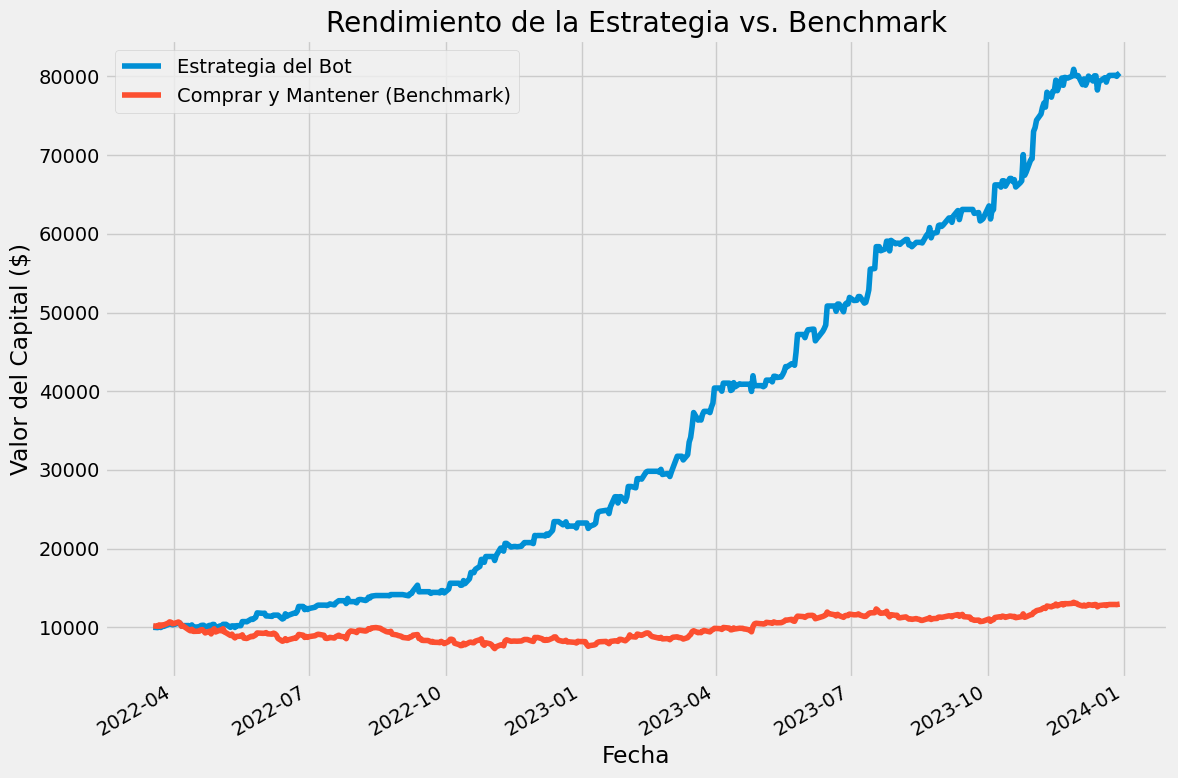


El backtesting ha finalizado. Revisa el gráfico para visualizar el rendimiento.


In [7]:
# -*- coding: utf-8 -*-
#
# Framework de Bot de Trading Avanzado
#
# Este script demuestra un enfoque sofisticado para el trading algorítmico,
# utilizando aprendizaje automático para predecir los movimientos del mercado.
# Está diseñado como un marco de trabajo (framework) para la investigación
# y el backtesting, no para el trading en vivo.
#
# Características clave:
# 1. Obtención de datos históricos de acciones.
# 2. Ingeniería de características (análisis de datos históricos para crear
#    variables que el modelo pueda usar).
# 3. Entrenamiento de un modelo de machine learning (Random Forest) para predecir
#    la dirección del precio.
# 4. Backtesting para simular el rendimiento de la estrategia.
# 5. Cálculo de métricas de rendimiento clave (Retorno Total, Sharpe Ratio,
#    Drawdown Máximo).
# 6. Visualización del rendimiento frente a un benchmark de "Comprar y Mantener"
#    (Buy & Hold).
#
# Para ejecutar este script, necesitas las siguientes bibliotecas. Instálalas
# usando pip:
# pip install yfinance pandas scikit-learn matplotlib numpy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def fetch_data(ticker, start_date, end_date):
    """
    Obtiene datos históricos de precios de un ticker específico.

    Args:
        ticker (str): Símbolo de la acción (por ejemplo, 'AAPL').
        start_date (str): Fecha de inicio en formato 'YYYY-MM-DD'.
        end_date (str): Fecha de fin en formato 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: DataFrame de pandas con los datos de precios.
    """
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            print(f"Error: No se encontraron datos para el ticker {ticker}.")
            return None
        print(f"Datos obtenidos para {ticker} desde {start_date} hasta {end_date}.")
        return data
    except Exception as e:
        print(f"Ocurrió un error al obtener los datos: {e}")
        return None

def create_features(data):
    """
    Crea características a partir de los datos históricos para el modelo de ML.

    Args:
        data (pd.DataFrame): DataFrame con datos de precios.

    Returns:
        pd.DataFrame: DataFrame con las características y la etiqueta (objetivo).
    """
    # Calcula el retorno diario
    data['Daily_Return'] = data['Close'].pct_change()

    # Crea la etiqueta de predicción: 1 si el precio sube, 0 si baja.
    # Usamos shift(-1) para que el modelo prediga el movimiento del día siguiente.
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

    # Crea características basadas en el pasado
    # Retornos pasados
    for i in range(1, 6): # Retornos de los últimos 5 días
        data[f'Return_Lag_{i}'] = data['Daily_Return'].shift(i)

    # Medias móviles (señales de tendencia)
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()

    # Volatilidad (desviación estándar de los retornos)
    data['Volatility_20'] = data['Daily_Return'].rolling(window=20).std()

    # --- Nuevas Características Avanzadas ---

    # Índice de Fuerza Relativa (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(com=14 - 1, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(com=14 - 1, adjust=False).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))

    # Convergencia/Divergencia de Medias Móviles (MACD)
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Elimina filas con valores NaN generados por las medias móviles y lags
    data.dropna(inplace=True)

    return data

def backtest_strategy(data, predictions, stop_loss_pct=0.03, take_profit_pct=0.05):
    """
    Simula la estrategia de trading con gestión de riesgos (stop-loss, take-profit).

    Args:
        data (pd.DataFrame): DataFrame con datos de precios y características.
        predictions (np.array): Array de predicciones del modelo.
        stop_loss_pct (float): Porcentaje de stop-loss.
        take_profit_pct (float): Porcentaje de take-profit.

    Returns:
        pd.DataFrame: DataFrame con la curva de capital y los retornos diarios.
    """
    backtest_df = data.copy()
    backtest_df['Prediction'] = predictions
    backtest_df['Strategy_Returns'] = 0.0

    initial_capital = 10000
    current_capital = initial_capital
    position_active = False
    entry_price = 0

    equity_curve = [initial_capital]

    # Iteramos día a día para simular la gestión de posiciones
    for i, row in backtest_df.iterrows():
        daily_return = 0.0

        # Lógica de entrada
        if row['Prediction'].item() == 1 and not position_active:
            position_active = True
            entry_price = row['Close'].item()

        # Lógica de gestión de posición
        if position_active:
            # Precios de stop-loss y take-profit
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            take_profit_price = entry_price * (1 + take_profit_pct)

            # Condición de salida por stop-loss o take-profit
            if row['Low'].item() <= stop_loss_price or row['High'].item() >= take_profit_price:
                exit_price = 0
                if row['Low'].item() <= stop_loss_price:
                    exit_price = stop_loss_price
                elif row['High'].item() >= take_profit_price:
                    exit_price = take_profit_price

                daily_return = (exit_price - entry_price) / entry_price
                position_active = False

            # Lógica de salida por predicción de bajada
            elif row['Prediction'].item() == 0:
                daily_return = row['Daily_Return'].item()
                position_active = False

            # Si se mantiene la posición
            else:
                daily_return = row['Daily_Return'].item()

        current_capital *= (1 + daily_return)
        equity_curve.append(current_capital)

    backtest_df['Strategy_Equity'] = equity_curve[1:] # Se omite el primer valor de 10000

    # Se recalcula la curva de capital de Buy & Hold para la misma duración
    backtest_df['Buy_Hold_Equity'] = initial_capital * (1 + backtest_df['Daily_Return']).cumprod()

    return backtest_df

def calculate_metrics(backtest_results):
    """
    Calcula métricas clave de rendimiento.

    Args:
        backtest_results (pd.DataFrame): DataFrame con los resultados del backtest.

    Returns:
        dict: Diccionario con las métricas calculadas.
    """
    metrics = {}

    # Retorno total
    total_return_strategy = (backtest_results['Strategy_Equity'].iloc[-1] / backtest_results['Strategy_Equity'].iloc[0]) - 1
    total_return_benchmark = (backtest_results['Buy_Hold_Equity'].iloc[-1] / backtest_results['Buy_Hold_Equity'].iloc[0]) - 1
    metrics['Total Return (Strategy)'] = f"{total_return_strategy:.2%}"
    metrics['Total Return (Benchmark)'] = f"{total_return_benchmark:.2%}"

    # Sharpe Ratio (basado en retornos anualizados)
    daily_returns = backtest_results['Strategy_Returns']
    risk_free_rate = 0.02 # Asumimos una tasa libre de riesgo del 2% anual
    sharpe_ratio = (daily_returns.mean() * 252 - risk_free_rate) / (daily_returns.std() * np.sqrt(252))
    metrics['Sharpe Ratio'] = f"{sharpe_ratio:.2f}"

    # Drawdown Máximo (pérdida máxima desde un pico)
    peak = backtest_results['Strategy_Equity'].cummax()
    drawdown = (backtest_results['Strategy_Equity'] - peak) / peak
    metrics['Max Drawdown'] = f"{drawdown.min():.2%}"

    return metrics

def plot_results(backtest_results):
    """
    Grafica la curva de capital de la estrategia vs. el benchmark.

    Args:
        backtest_results (pd.DataFrame): DataFrame con los resultados del backtest.
    """
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 8))

    backtest_results['Strategy_Equity'].plot(ax=ax, label='Estrategia del Bot')
    backtest_results['Buy_Hold_Equity'].plot(ax=ax, label='Comprar y Mantener (Benchmark)')

    ax.set_title(f'Rendimiento de la Estrategia vs. Benchmark')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor del Capital ($)')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    # --- Parámetros de Configuración ---
    TICKER = 'MSFT'
    START_DATE = '2015-01-01'
    END_DATE = '2023-12-31'
    TEST_SIZE = 0.2 # 20% de los datos para la prueba final
    N_SPLITS = 5  # Número de divisiones para la validación cruzada
    STOP_LOSS_PCT = 0.03
    TAKE_PROFIT_PCT = 0.05

    # --- 1. Obtención y Preprocesamiento de Datos ---
    print("Paso 1: Obteniendo y preparando los datos...")
    data = fetch_data(TICKER, START_DATE, END_DATE)
    if data is None:
        exit()

    processed_data = create_features(data)

    # Definir características (X) y objetivo (y)
    features = [col for col in processed_data.columns if col not in ['Close', 'High', 'Low', 'Daily_Return', 'Target']]
    X = processed_data[features]
    y = processed_data['Target']

    # División de los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)

    # --- 2. Entrenamiento y Optimización del Modelo con Validación Cruzada ---
    print("Paso 2: Entrenando y optimizando el modelo en los datos de entrenamiento...")

    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10]
    }

    model = RandomForestClassifier(random_state=42)

    # GridSearchCV para encontrar los mejores parámetros en el conjunto de entrenamiento
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")

    # Reentrenar el modelo final con todos los datos de entrenamiento
    best_model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba final
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2%}")

    # --- 3. Backtesting de la Estrategia ---
    print("Paso 3: Realizando el backtesting de la estrategia con gestión de riesgos...")
    # Creamos un DataFrame para el backtesting con los datos del período de prueba
    backtest_data = processed_data.loc[X_test.index]
    backtest_results = backtest_strategy(backtest_data, y_pred, STOP_LOSS_PCT, TAKE_PROFIT_PCT)

    # --- 4. Análisis de Rendimiento y Visualización ---
    print("Paso 4: Calculando métricas y visualizando resultados...")
    performance_metrics = calculate_metrics(backtest_results)

    print("\n--- Métricas de Rendimiento ---")
    for metric, value in performance_metrics.items():
        print(f"{metric}: {value}")

    plot_results(backtest_results)
    print("\nEl backtesting ha finalizado. Revisa el gráfico para visualizar el rendimiento.")